In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

pd.options.display.max_columns = 500

In [ ]:
##

In [261]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [20]:
# grab all files ends with .csv
!ls | grep '.csv$'

survey-results-public.csv
survey-results-schema.csv


In [390]:
df = pd.read_csv('./survey-results-public.csv')
schema = pd.read_csv('./survey-results-schema.csv')

In [56]:
df.head(2)

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0


In [57]:
schema.head(2)

,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?


In [245]:
def get_description(col_name, schema = schema):
    
    '''
    INPUT - schema: pandas dataframe - with the schema of the developers survey
            col_name: string - the name of the column you would like to know about
    OUTPUT - 
            desc: string - the description of the column
    
    '''
    return list(schema[schema.Column == col_name].Question)[0]

In [246]:
# Examine the question for CousinEducation column
get_description('CousinEducation')

"Let's pretend you have a distant cousin. They are 24 years old, have a college degree in a field not related to computer programming, and have been working a non-coding job for the last two years. They want your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to your cousin?\nLet's pretend you have a distant cousin named Robert. He is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. He wants your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to Robert?\nLet's pretend you have a distant cousin named Alice. She is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. She wants your advice on how to switch to a career as a software developer. Which 

### How to break into the field?

In [107]:
# Get a sense of the distribution of recommendations
def get_possible_val(col_name, df = df):
    '''
    Output all possible values in a column
    
    INPUT - df: Pandas data frame
            col_name: column name 
            
    OUTPUT - list, all possible values in a column
    
    '''
    
    #Provide a pandas series of the counts for each CousinEducation status
    cousin_ed = df[col_name].value_counts().reset_index()
    
    # cousin_ed.rename(columns = {'index':'k', col_name:'v'}, inplace = True)
    
    return list(set([v.strip() for s in cousin_ed['index'] for v in s.split(';')]))

In [80]:
poss_val = get_possible_vals('CousinEducation')

In [81]:
poss_val

['None of these', 'Return to college', 'Contribute to open source', 'Participate in online coding competitions', 'Buy books and work through the exercises', 'Take online courses', 'Get a job as a QA tester', "Master's degree", 'Participate in hackathons', 'Bootcamp', 'Part-time/evening courses', 'Other', 'Conferences/meet-ups']

In [196]:
def clean_and_plot(col_name, df = df, title = None, plot = True, show = False):
    '''
    Clean and plot the countplot of each category in selected column
    
    INPUT: col_name: column name you are interested in plotting
           df: pandas dataframe
           title: User-specified plot title
           plot: Enable/Disable plotting
           show: Bool providing if output is needed
           
    OUTPUT: data frame with value counts
    
    '''
    
    cousin_ed = df[col_name].value_counts().reset_index()
    
    res = []
    for s in cousin_ed['index']:
        res.append(s.split(';')[0])
    
    d = Counter(res)
    
    temp = pd.DataFrame.from_dict(d, orient='index').reset_index()
    temp.rename(columns = {'index':'value', 0:'count'}, inplace = True)
    temp.sort_values(by = 'count', ascending = False, inplace = True)
    temp['prop'] = round(temp['count'] / sum(temp['count']),2)
    
    if plot:
        fig, ax = plt.subplots(figsize = (8,5))
        sns.barplot(x = 'prop', y = 'value', data = temp)
        sns.despine()
        plt.show()
    
    if show:
        return temp

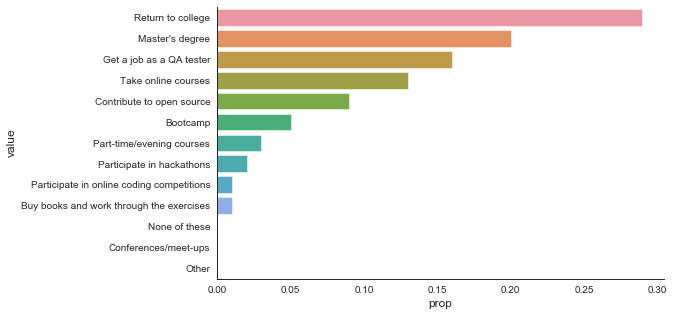

In [200]:
temp = clean_and_plot('CousinEducation', df = df, show = True)

In [201]:
higher_ed_check = set(["Master's degree", "Doctoral", "Professional degree"])
# Create new column differentiating higher edu
df['HigherEd'] = (df['FormalEducation']
                  .apply(lambda x: 1 if x in higher_ed_check else 0))

ed_0 = df[df['HigherEd'] == 0]
ed_1 = df[df['HigherEd'] == 1]                    
                         

In [226]:
ed_1_perc = clean_and_plot(df = ed_1, 
                           col_name = 'CousinEducation',
                           title = 'Higher Formal Education', 
                           plot = False, show = True)
ed_1_perc.set_index('value', inplace = True)

In [228]:
ed_0_perc = clean_and_plot(df = ed_0, 
                           col_name = 'CousinEducation',
                           title = 'Non-Higher Formal Education', 
                           plot = False, show = True)
ed_0_perc.set_index('value', inplace = True)

In [238]:
comp_df = pd.merge(ed_1_perc, ed_0_perc, left_index=True, right_index=True)

In [239]:
# select only the proportion column
comp_df = comp_df[['prop_x', 'prop_y']]

In [241]:
# rename the columns
comp_df.columns = ['ed_1_perc', 'ed_0_perc']
comp_df['Diff'] = comp_df['ed_1_perc'] - comp_df['ed_0_perc']

In [265]:
comp_df.style.bar(subset=['Diff'], align='mid', color=['#d65f5f', '#5fba7d'])

,ed_1_perc,ed_0_perc,Diff
value,,,
Return to college,0.270000,0.300000,-0.030000
Master's degree,0.200000,0.190000,0.010000
Get a job as a QA tester,0.160000,0.170000,-0.010000
Take online courses,0.150000,0.130000,0.020000
Contribute to open source,0.100000,0.090000,0.010000
Bootcamp,0.040000,0.050000,-0.010000
Part-time/evening courses,0.030000,0.030000,0.000000
Participate in hackathons,0.020000,0.020000,0.000000
Participate in online coding competitions,0.010000,0.010000,0.000000


In [391]:
# Extract only the numerical columns and job-related categorical cols
num_col = list(df.select_dtypes(['int','float']).columns)
cat_col = list(df.filter(regex = '(Job)').columns)

In [392]:
df = df[num_col + cat_col]

In [393]:
df.head()

,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary,YearsCodedJob,YearsCodedJobPast,JobSatisfaction,JobSecurity,JobSeekingStatus,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,JobProfile,StackOverflowJobListing,StackOverflowJobSearch
0,1,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,NaN,Strongly agree,"I'm not actively looking, but I am open to new...",Not applicable/ never,Very important,Very important,Important,Very important,Very important,Very important,Important,Very important,Very important,Very important,Very important,Very important,Somewhat important,Not very important,Somewhat important,Other,Once or twice,Haven't done at all
1,2,NaN,NaN,NaN,8.0,NaN,37500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,Once or twice,Once or twice
2,3,8.0,9.0,NaN,8.0,113750.0,NaN,20 or more years,NaN,9.0,Agree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Haven't done at all,Haven't done at all
3,4,6.0,3.0,5.0,10.0,NaN,NaN,9 to 10 years,NaN,3.0,Somewhat agree,I am actively looking for a job,Between 2 and 4 years ago,Somewhat important,Somewhat important,Somewhat important,Important,Important,Very important,Important,Very important,Important,Somewhat important,Not very important,Very important,Important,Very important,Very important,LinkedIn; Other,At least once each week,At least once each week
4,5,6.0,8.0,NaN,NaN,NaN,NaN,10 to 11 years,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Preprocessing

In [397]:
def create_dummy_df(df, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    
    # Drop the rows with missing response values
    df = df.dropna(subset = ['Salary'], axis = 0)
    
    # Drop columns with all missing values
    df = df.dropna(how = 'all', axis = 1)
    
    # Drop redundant columns Respondent
    df = df.drop(['Respondent','JobSatisfaction'], axis = 1)
    
    # Dummy coding for cat columns
    cat_cols = df.select_dtypes('object').columns
    for col in cat_cols:
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], drop_first=True, dummy_na=dummy_na)], axis=1)
        
    # Mean imputation for num columns
    df = df.apply(lambda x: x.fillna(x.mean()))
               
    return df

In [398]:
# Create dummy variable for each categorical feature and drop original cat columns
df_new = create_dummy_df(df, dummy_na=False)

df_new.head()

,CareerSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,10 to 11 years,11 to 12 years,12 to 13 years,13 to 14 years,14 to 15 years,15 to 16 years,16 to 17 years,17 to 18 years,18 to 19 years,19 to 20 years,2 to 3 years,20 or more years,3 to 4 years,4 to 5 years,5 to 6 years,6 to 7 years,7 to 8 years,8 to 9 years,9 to 10 years,Less than a year,11 to 12 years,6 to 7 years,Less than a year,Disagree,Somewhat agree,Strongly agree,Strongly disagree,I am not interested in new job opportunities,"I'm not actively looking, but I am open to new opportunities",Between 2 and 4 years ago,Less than a year ago,More than 4 years ago,Not applicable/ never,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,CW_Jobs; Dice; Glassdoor; Hired.com; Indeed; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk,CW_Jobs; Dice; Hired.com; Indeed; JobSite.co.uk; LinkedIn,CW_Jobs; Dice; Hired.com; Indeed; LinkedIn; Monster; Talent.io; Total_Jobs,CW_Jobs; Dice; Indeed; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk,CW_Jobs; Dice; Indeed; JobSite.co.uk; LinkedIn; Reed.co.uk,CW_Jobs; Dice; Indeed; JobSite.co.uk; Reed.co.uk,CW_Jobs; Dice; Indeed; LinkedIn; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Dice; Indeed; Monster; Reed.co.uk,CW_Jobs; Dice; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Dice; JobSite.co.uk; LinkedIn; Total_Jobs,CW_Jobs; Glassdoor; Hired.com; Indeed; JobSite.co.uk; LinkedIn; Monster,CW_Jobs; Glassdoor; Hired.com; Indeed; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Glassdoor; Hired.com; JobSite.co.uk; LinkedIn; Monster; Other,CW_Jobs; Glassdoor; Hired.com; JobSite.co.uk; LinkedIn; Talent.io; Total_Jobs,CW_Jobs; Glassdoor; Hired.com; LinkedIn,CW_Jobs; Glassdoor; Indeed; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk,CW_Jobs; Glassdoor; Indeed; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Glassdoor; Indeed; LinkedIn; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Glassdoor; JobSite.co.uk; LinkedIn,CW_Jobs; Glassdoor; JobSite.co.uk; LinkedIn; Monster; Other; Total_Jobs,CW_Jobs; Glassdoor; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk,CW_Jobs; Glassdoor; LinkedIn; Monster; Total_Jobs,CW_Jobs; Glassdoor; LinkedIn; Reed.co.uk; Total_Jobs,CW_Jobs; Hired.com; LinkedIn,CW_Jobs; Hired.com; Total_Jobs,CW_Jobs; Indeed; JobSite.co.uk,CW_Jobs; Indeed; JobSite.co.uk; LinkedIn,CW_Jobs; Indeed; JobSite.co.uk; LinkedIn; Monster,CW_Jobs; Indeed; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk,CW_Jobs; Indeed; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Indeed; JobSite.co.uk; LinkedIn; Reed.co.uk; Total_Jobs,CW_Jobs; Indeed; JobSite.co.uk; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Indeed; LinkedIn,CW_Jobs; Indeed; LinkedIn; Monster; Other; Reed.co.uk,CW_Jobs; Indeed; LinkedIn; Monster; Reed.co.uk,CW_Jobs; Indeed; LinkedIn; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Indeed; LinkedIn; Reed.co.uk,CW_Jobs; Indeed; Monster,CW_Jobs; Indeed; Reed.co.uk,CW_Jobs; Jo

In [400]:
df_new.describe()

,CareerSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,10 to 11 years,11 to 12 years,12 to 13 years,13 to 14 years,14 to 15 years,15 to 16 years,16 to 17 years,17 to 18 years,18 to 19 years,19 to 20 years,2 to 3 years,20 or more years,3 to 4 years,4 to 5 years,5 to 6 years,6 to 7 years,7 to 8 years,8 to 9 years,9 to 10 years,Less than a year,11 to 12 years,6 to 7 years,Less than a year,Disagree,Somewhat agree,Strongly agree,Strongly disagree,I am not interested in new job opportunities,"I'm not actively looking, but I am open to new opportunities",Between 2 and 4 years ago,Less than a year ago,More than 4 years ago,Not applicable/ never,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,Not at all important,Not very important,Somewhat important,Very important,CW_Jobs; Dice; Glassdoor; Hired.com; Indeed; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk,CW_Jobs; Dice; Hired.com; Indeed; JobSite.co.uk; LinkedIn,CW_Jobs; Dice; Hired.com; Indeed; LinkedIn; Monster; Talent.io; Total_Jobs,CW_Jobs; Dice; Indeed; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk,CW_Jobs; Dice; Indeed; JobSite.co.uk; LinkedIn; Reed.co.uk,CW_Jobs; Dice; Indeed; JobSite.co.uk; Reed.co.uk,CW_Jobs; Dice; Indeed; LinkedIn; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Dice; Indeed; Monster; Reed.co.uk,CW_Jobs; Dice; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Dice; JobSite.co.uk; LinkedIn; Total_Jobs,CW_Jobs; Glassdoor; Hired.com; Indeed; JobSite.co.uk; LinkedIn; Monster,CW_Jobs; Glassdoor; Hired.com; Indeed; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Glassdoor; Hired.com; JobSite.co.uk; LinkedIn; Monster; Other,CW_Jobs; Glassdoor; Hired.com; JobSite.co.uk; LinkedIn; Talent.io; Total_Jobs,CW_Jobs; Glassdoor; Hired.com; LinkedIn,CW_Jobs; Glassdoor; Indeed; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk,CW_Jobs; Glassdoor; Indeed; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Glassdoor; Indeed; LinkedIn; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Glassdoor; JobSite.co.uk; LinkedIn,CW_Jobs; Glassdoor; JobSite.co.uk; LinkedIn; Monster; Other; Total_Jobs,CW_Jobs; Glassdoor; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk,CW_Jobs; Glassdoor; LinkedIn; Monster; Total_Jobs,CW_Jobs; Glassdoor; LinkedIn; Reed.co.uk; Total_Jobs,CW_Jobs; Hired.com; LinkedIn,CW_Jobs; Hired.com; Total_Jobs,CW_Jobs; Indeed; JobSite.co.uk,CW_Jobs; Indeed; JobSite.co.uk; LinkedIn,CW_Jobs; Indeed; JobSite.co.uk; LinkedIn; Monster,CW_Jobs; Indeed; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk,CW_Jobs; Indeed; JobSite.co.uk; LinkedIn; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Indeed; JobSite.co.uk; LinkedIn; Reed.co.uk; Total_Jobs,CW_Jobs; Indeed; JobSite.co.uk; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Indeed; LinkedIn,CW_Jobs; Indeed; LinkedIn; Monster; Other; Reed.co.uk,CW_Jobs; Indeed; LinkedIn; Monster; Reed.co.uk,CW_Jobs; Indeed; LinkedIn; Monster; Reed.co.uk; Total_Jobs,CW_Jobs; Indeed; LinkedIn; Reed.co.uk,CW_Jobs; Indeed; Monster,CW_Jobs; Indeed; Reed.co.uk,CW_Jobs; Jo

### Modeling

In [401]:
def clean_fit_linear_mod(df, response_col, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    Your function should:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''

    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test


#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df_new, 'Salary', dummy_na=False)

In [403]:
print(train_score)
print(test_score)

0.34018592271503845
-3.0048809528159604e+26
